# Компьютерний практикум №5. Інтерполяція
Шкаліков Олег, ФІ-81

In [1]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial as poly
from matplotlib import pyplot as plt

In [2]:
def func(x):
    return x * np.tan(x)

In [3]:
x = np.linspace(-np.pi / 3, np.pi / 3, 10)
y = func(x)

In [4]:
def plot_interpolation(interpolation, func=func, x=x, y=y, t=np.linspace(-np.pi / 3, np.pi / 3, 1000)):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Графік функцій")
    plt.plot(x, y, 'o', label='Вихідні дані')
    plt.plot(t, interpolation(t), label='Інтерполяція')
    plt.plot(t, func(t), label = 'Вихідна функція')    
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Графік модуля різниці")
    plt.plot(t, np.abs(interpolation(t)-func(t)))

## Поліноми Лагранжа

In [5]:
def lagrange(x, y):
    p = poly([0])
    for i in range(x.shape[0]):
        basePoly = poly([1])
        for j in range(x.shape[0]):
            if i != j:
                delta = x[i] - x[j]
                t = poly([-x[j]/delta, 1/delta])
                basePoly *= t
        p += basePoly * y[i]
            
    return p

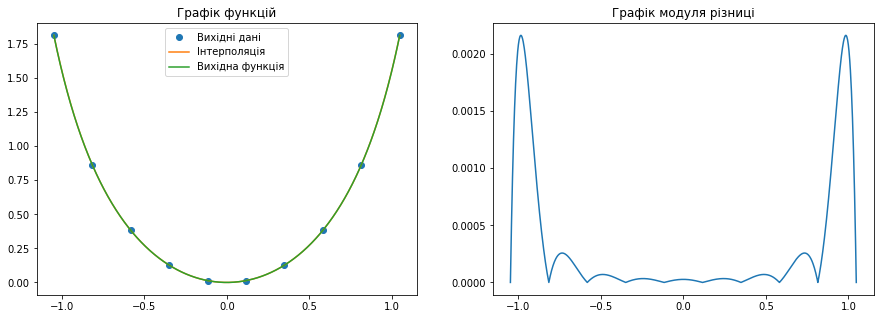

In [6]:
plot_interpolation(lagrange(x,y))

## Метод Ньютона

In [7]:
def newton(x, y):    
    h = y        
    p = poly([y[0]])
    tempDx = poly([1])
    for i in range(1, x.shape[0]):             
        h = np.diff(h) / np.array([x[j+i-1] - x[j-1] for j in range(1, h.shape[0])])        
        tempDx *= poly([-x[i-1], 1])
        p += tempDx * h[0]
        
    return p

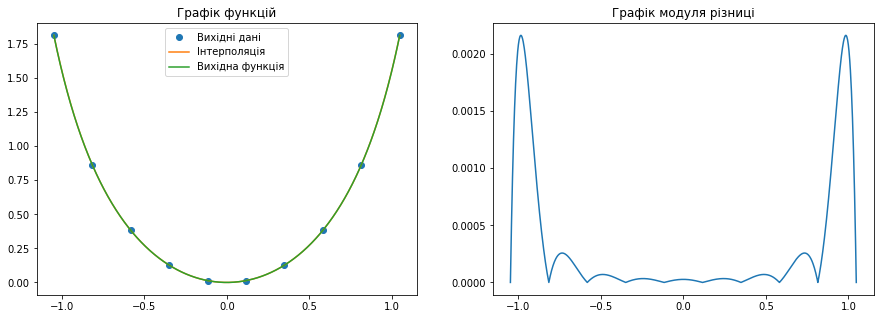

In [8]:
plot_interpolation(newton(x,y))

## Кубічні сплайни

In [9]:
class CubicSpline:
    def __init__(self, x, y):
        assert x.shape[0] == y.shape[0]         
        self.__x = x
        self.__calculate_coeffs__(x, y)        
    
    def __tridiagonal_solve__(self, a, b, c, d):
        c = np.copy(c)
        c[0] /= b[0]
        d[0] /= b[0]
                        
        for i in range(1, b.shape[0]):
            temp = b[i] - c[i-1]*a[i-1]
            c[i] /= temp
            d[i] = (d[i] - d[i-1]*a[i-1]) / temp
            
        x = np.empty_like(d)
        x[-1] = d[-1]
        for j in range(d.shape[0] - 2, -1, -1):            
            x[j] = d[j] - c[j] * x[j+1]            
        
        return x
        
    def __calculate_coeffs__(self, x, y):        
        h = np.diff(x)         
        dy = np.diff(y)            
                
        c = np.zeros(x.shape[0])
        vec = 3 * (dy[1:] / h[1:] - dy[:-1] / h[:-1])        
        c[1:-1] = self.__tridiagonal_solve__(h[:-1], 2*(h[:-1] + h[1:]), h[1:], vec)
            
        d = np.diff(c) / (3*h)
        b = dy / h - 1/3 * h * (2 * c[:-1] + c[1:])
        
        self.__a = y[:-1]
        self.__b = b
        self.__c = c[:-1]
        self.__d = d
        
    def __call__(self, x):
        result = np.zeros_like(x)
        for j, t in enumerate(x):
            
            i = np.argmax(self.__x > t) - 1
            if self.__x[-1] == t:
                i = self.__b.shape[0] - 1     
            if i < 0:
                raise ValueError("Argument out of bounds")
                                                
            dx = (t - self.__x[i])           
            result[j] = self.__a[i] + self.__b[i] * dx + self.__c[i] * dx**2  + self.__d[i] * dx**3                        
        return result

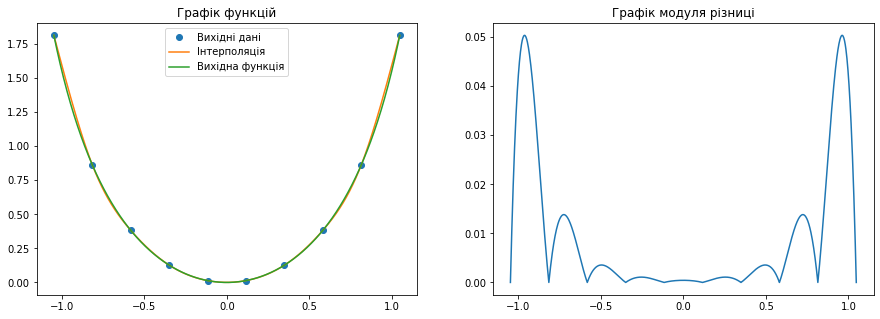

In [10]:
plot_interpolation(CubicSpline(x,y))